In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import display

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763729,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939863,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992714,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256903,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362576,531500
...,...,...,...,...,...,...
2024-06-03,529.020020,529.309998,522.599976,527.799988,527.799988,46835700
2024-06-04,526.460022,529.150024,524.960022,528.390015,528.390015,34632700
2024-06-05,530.770020,534.690002,528.729980,534.669983,534.669983,47610400


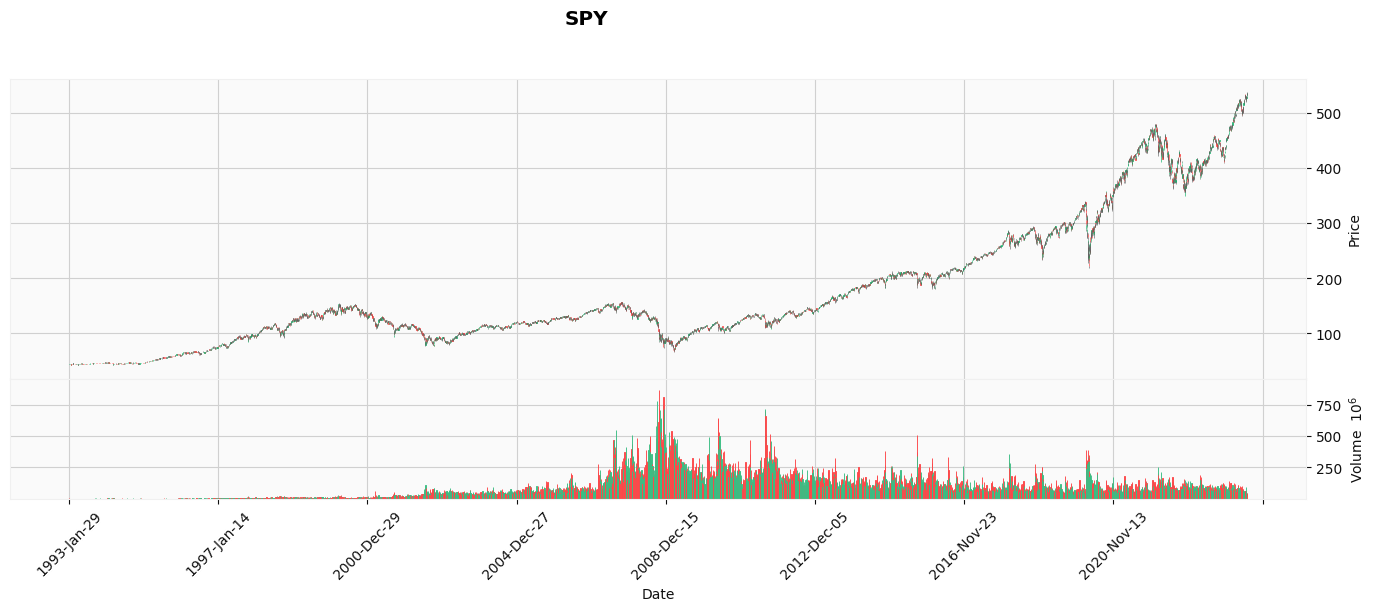

In [34]:
SPY = pd.read_csv('./data/SPY.csv', parse_dates=['Date'], index_col='Date')
# SPY.drop(columns=['Adj Close'], inplace=True)
display(SPY)

mpf.plot(
    SPY,
    title="SPY",
    xlabel="Date",
    type="candle",
    volume=True,
    figsize=(18, 6),
    style="yahoo",
    warn_too_much_data=len(SPY) + 1,
)

In [35]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(SPY[['Adj Close']].values)
scaled_data

array([[5.86855492e-04],
       [9.32077056e-04],
       [1.03566469e-03],
       ...,
       [1.00000000e+00],
       [9.99980380e-01],
       [9.98706457e-01]])

In [39]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10  # for example, use last 60 days' data to predict the next day
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = scaler.inverse_transform(y_test)

print(f"{X_train.shape=}")
print(f"{X_train.device=}")
print(f"{y_train.shape=}")
print(f"{y_train.device=}")
print(f"{X_test.shape=}")
print(f"{X_test.device=}")
print(f"{y_test.shape=}")

X_train.shape=torch.Size([6308, 10, 1])
X_train.device=device(type='mps', index=0)
y_train.shape=torch.Size([6308, 1])
y_train.device=device(type='mps', index=0)
X_test.shape=torch.Size([1578, 10, 1])
X_test.device=device(type='mps', index=0)
y_test.shape=(1578, 1)


In [53]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [54]:
# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [55]:
summary(
    model,
    input_size=(1, 10, 1),
    col_names=["input_size", "output_size", "num_params"],
    device=device,
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMNetwork                              [1, 10, 1]                [1, 1]                    --
├─LSTM: 1-1                              [1, 10, 1]                [1, 10, 50]               31,000
├─Linear: 1-2                            [1, 50]                   [1, 1]                    51
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.31
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13

100%|██████████| 500/500 [00:31<00:00, 16.01it/s, Loss: 0.00949508510529995]   


Total Epochs: 1000


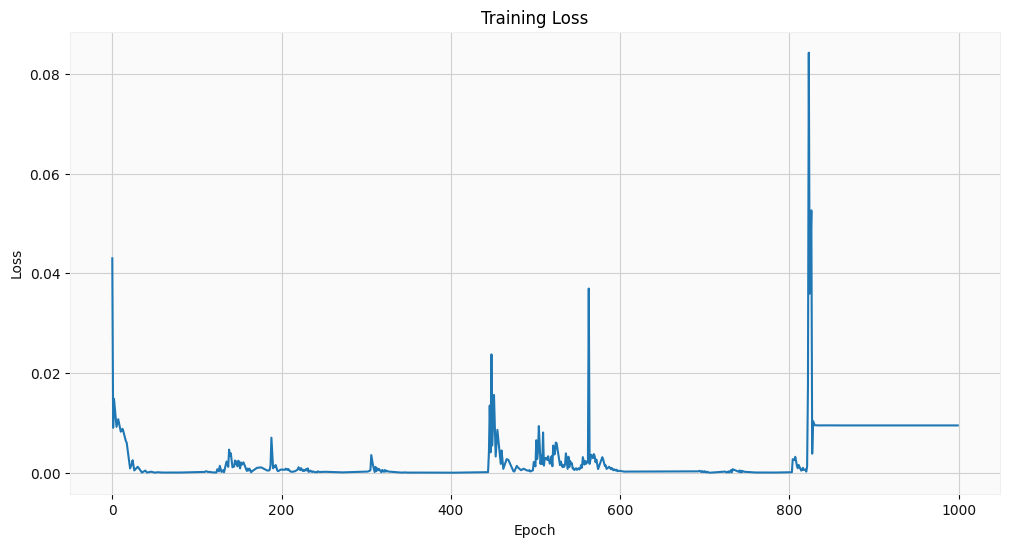

In [57]:
reset = False
if reset:
    loss_line = []

epochs = 500
for epoch in (pbar := tqdm(range(epochs))):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    pbar.set_postfix_str(f"Loss: {loss.item()}")
    loss_line.append(loss.item())
    loss.backward()
    optimizer.step()

print(f"Total Epochs: {len(loss_line)}")
plt.figure(figsize=(12, 6))
plt.plot(loss_line)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [62]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = y_test_pred.to('cpu')

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())

94.64156


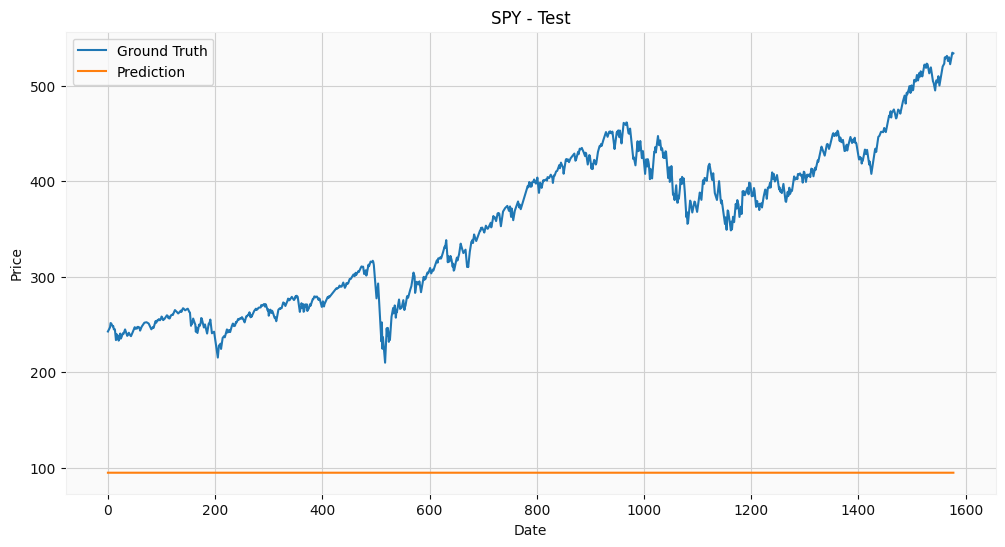

In [63]:
print(y_test_pred[-1][0])

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Ground Truth')
plt.plot(y_test_pred, label='Prediction')
plt.title('SPY - Test')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()